In [2]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import os
import time

Leemos las imagenes de una carpeta con cv2 y os las guardamos en un numpy array

In [51]:

def read_images(folder_path):
    images = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg')):
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)
                images.append(image)
    return np.array(images)

t = time.time() 
images = read_images("../backend/fileRecognition/1604259")
print("Time: ", time.time() - t)
    
images.shape

Time:  0.08721494674682617


(49, 240, 320, 3)

In [59]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import os
import time

        
def normalize_images(images):
    normalized_images = []
    for image in images:
                # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        normalized_image = cv2.normalize(gray_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)                
        normalized_images.append(normalized_image)
    return np.array(normalized_images)


#normalized_images = normalize_images(images) 
normalized_images = images

train_images = normalized_images[:int(len(images)*0.8)]
test_images = normalized_images[int(len(images)*0.8):]

train_images.shape, test_images.shape



((39, 240, 320, 3), (10, 240, 320, 3))

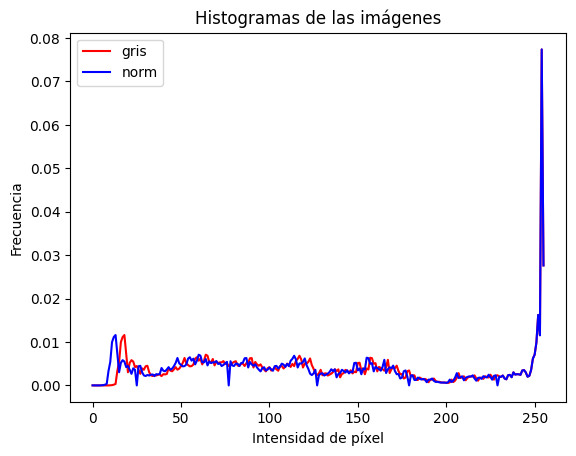

In [60]:
imagen_bgr = cv2.imread('../backend/fileRecognition/1604259/frame_1.jpg')

imagen_gris = cv2.cvtColor(imagen_bgr, cv2.COLOR_BGR2GRAY)

imagen_gris_norm = cv2.normalize(imagen_gris, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)


histograma_gris = cv2.calcHist([imagen_gris], [0], None, [256], [0, 256])
histograma_gris_norm = cv2.calcHist([imagen_gris_norm], [0], None, [256], [0, 256])

histograma_gris_norm /= histograma_gris_norm.sum()
histograma_gris /= histograma_gris.sum()



# Visualizar los histogramas (opcional)
plt.plot(histograma_gris, color='r')
plt.plot(histograma_gris_norm, color='b')
plt.title('Histogramas de las imágenes')
plt.xlabel('Intensidad de píxel')
plt.ylabel('Frecuencia')
plt.legend(['gris', 'norm'])
plt.show()



In [77]:
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

train_labels = np.array([1 for _ in range(len(train_images))])
test_labels = np.array([1 for _ in range(len(test_images))])

train_images.shape , test_images.shape, train_labels.shape, test_labels.shape


((39, 240, 320, 3), (10, 240, 320, 3), (39,), (10,))

In [78]:
from keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(240, 320, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 238, 318, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 119, 159, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 117, 157, 64)      18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 58, 78, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 56, 76, 128)       73856     
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 28, 38, 128)      

In [79]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])        

In [81]:


history = model.fit(train_images, train_labels, epochs=30, batch_size=32, validation_data=(test_images, test_labels))

Epoch 1/30
2/2 [==============================] - 4s 735ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 9.8651e-04 - val_acc: 1.0000
Epoch 2/30
2/2 [==============================] - 3s 735ms/step - loss: 9.7612e-04 - acc: 1.0000 - val_loss: 8.7475e-04 - val_acc: 1.0000
Epoch 3/30
2/2 [==============================] - ETA: 0s - loss: 8.6577e-04 - acc: 1.0000

KeyboardInterrupt: 

In [87]:
!pip install torch facenet_pytorch

  Using cached torch-2.2.1-cp310-none-macosx_10_9_x86_64.whl.metadata (25 kB)
  Using cached facenet_pytorch-2.5.3-py3-none-any.whl.metadata (13 kB)
  Using cached filelock-3.13.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached sympy-1.12-py3-none-any.whl.metadata (12 kB)
  Using cached torchvision-0.17.1-cp310-cp310-macosx_10_13_x86_64.whl.metadata (6.6 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.8/150.8 MB 4.8 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 8.4 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 6.6 MB/s eta 0:00:00:00:010:01


In [88]:
import torch
from facenet_pytorch import MTCNN
import numpy as np

# Detectar si se dispone de GPU cuda
# ==============================================================================
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

# Detector MTCNN
# ==============================================================================
mtcnn = MTCNN(
            select_largest = True,
            min_face_size  = 20,
            thresholds     = [0.6, 0.7, 0.7],
            post_process   = False,
            image_size     = 160,
            device         = device
        )

/opt/anaconda3/envs/kaggle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on device: cpu


In [92]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt

imagen_1 = Image.open('./fileRecognition/1604259/frame_1.jpg')

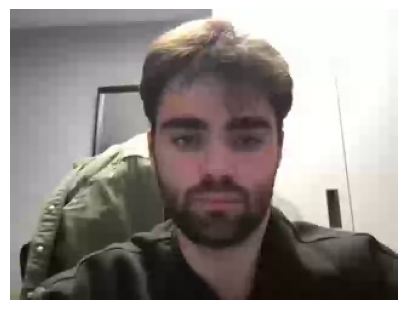

In [94]:
plt.figure(figsize=(5, 4))
plt.imshow(imagen_1)
plt.axis('off');



In [93]:
boxes, probs, landmarks = mtcnn.detect(imagen_1, landmarks=True)
print('Bounding boxes:', boxes)
print('Probability:', probs)
print('landmarks:', landmarks)

Bounding boxes: [[114.7706069946289 48.04239273071289 222.42576599121094
  192.2689666748047]]
Probability: [0.9999927282333374]
landmarks: [[[146.77963256835938 107.4893569946289]
  [196.20059204101562 107.68023681640625]
  [170.9300079345703 135.3433837890625]
  [150.85452270507812 161.0325927734375]
  [193.01194763183594 161.0452423095703]]]


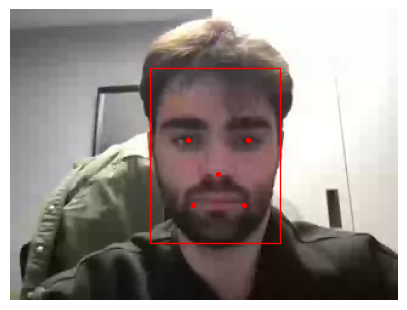

In [95]:
box = boxes[0]
landmark = landmarks[0]
fig, ax  = plt.subplots(figsize=(5, 4))
ax.imshow(imagen_1)
ax.scatter(landmark[:, 0], landmark[:, 1], s=8, c= 'red')
rect = plt.Rectangle(
            xy     = (box[0], box[1]),
            width  = box[2] - box[0],
            height = box[3] - box[1],
            fill   = False,
            color  = 'red'
       )
ax.add_patch(rect)
ax.axis('off');

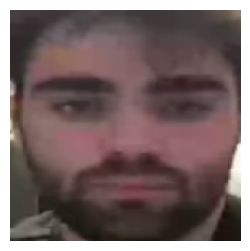

In [97]:
face = mtcnn.forward(imagen_1)
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
face = face.permute(1, 2, 0).int().numpy()
ax.imshow(face)
plt.axis('off');

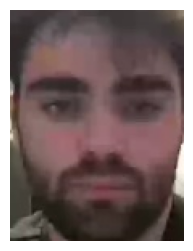

In [100]:
boxes, probs, landmarks = mtcnn.detect(imagen_1, landmarks=True)
x1, y1, x2, y2 = boxes[0].astype(int)
recorte_cara = np.array(imagen_1)[y1:y2, x1:x2]

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(recorte_cara)
plt.axis('off');

In [101]:
from facenet_pytorch import InceptionResnetV1
encoder = InceptionResnetV1(pretrained='vggface2', classify=False, device=device).eval()

100%|██████████| 107M/107M [00:18<00:00, 5.95MB/s] 


In [102]:
# Detección de cara
# ==============================================================================
cara = mtcnn(imagen_1)
# Embedding de cara
# ==============================================================================
embedding_cara = encoder.forward(cara.reshape((1,3, 160, 160))).detach().cpu()
embedding_cara

tensor([[ 5.2714e-02, -1.5367e-02,  3.8515e-02,  2.3695e-02,  7.6605e-02,
         -4.9238e-02, -1.8388e-02, -2.7683e-03, -2.8977e-02, -3.0284e-02,
         -7.9985e-02, -1.5205e-02, -9.1364e-02, -1.8822e-02,  7.1203e-02,
         -4.5230e-02,  2.7068e-03, -1.3576e-02,  1.8486e-02,  3.9203e-02,
          2.3628e-02,  4.4389e-02, -4.2476e-02,  5.1328e-03,  1.5217e-02,
          1.3024e-02,  1.2352e-01,  2.3334e-03,  4.2029e-02, -8.3833e-02,
         -9.5841e-03,  2.9210e-02,  3.5591e-02,  9.3812e-03,  6.5825e-02,
         -1.3091e-03, -7.6090e-02,  2.6632e-02, -1.8283e-02,  2.0431e-02,
         -8.6462e-03,  1.8448e-02,  2.0923e-02, -1.2793e-01, -2.8199e-02,
         -5.1629e-02,  2.2664e-02, -1.7007e-02, -5.8447e-02,  4.3329e-02,
          1.0136e-01,  7.0586e-02,  7.3226e-02,  5.6028e-02, -1.8506e-02,
         -5.4423e-02,  3.5523e-02,  8.1687e-02, -1.4699e-02,  2.7958e-02,
         -1.1483e-02, -6.6647e-02,  6.5848e-02, -3.0337e-02,  7.0319e-03,
          2.2172e-02,  3.6363e-02, -2.

In [103]:
# Detector MTCNN
# ==============================================================================
mtcnn = MTCNN(
            keep_all      = True,
            min_face_size = 20,
            thresholds    = [0.6, 0.7, 0.7],
            post_process  = False,
            image_size    = 160,
            device        = device
        )

(-0.5, 159.5, 159.5, -0.5)

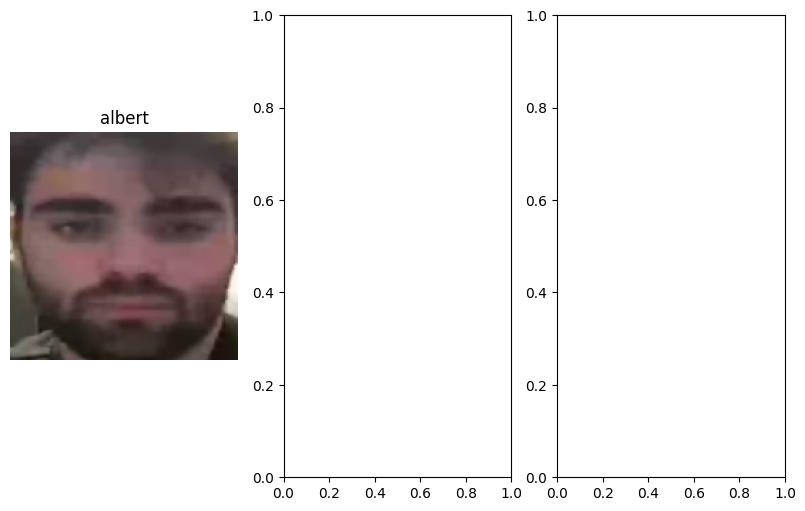

In [106]:
phil_1 = mtcnn(imagen_1)[0]
# Representación con matplotlib
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))

face = phil_1.permute(1, 2, 0).int().numpy()
axs[0].imshow(face)
axs[0].set_title('albert')
axs[0].axis('off')


In [111]:
embeding_phil_1 = encoder.forward(phil_1.reshape((1,3, 160, 160))).detach().cpu()


In [113]:
# Distancias entre embeddings de caras
# ==============================================================================
from scipy.spatial.distance import euclidean
print(f"Distancia entre la misma imagen Phil: {euclidean(embeding_phil_1, embeding_phil_1)}")


ValueError: Input vector should be 1-D.